In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize
from root_numpy import tree2array,array2tree,array2root
import ROOT

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Embedding, LSTM

Welcome to JupyROOT 6.10/02


Using TensorFlow backend.


CPU times: user 4.26 s, sys: 1.35 s, total: 5.61 s
Wall time: 7.76 s


In [2]:
%%time
from pyts.transformation import GADF, GASF

from sklearn.preprocessing import normalize
from root_numpy import tree2array,array2tree,array2root
import ROOT
import keras

training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2
classes = 7

# Slightly different , just the first 4096 of waveform(full 4480, for ease of operations)
def reader_pmt(path):
    extra = np.arange(4096, 4480)
    x_file = ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x_pmtall = tree2array(x_tree, branches="PMTALL")
    x = np.delete(x_pmtall, extra, axis=1)
    return x

def reader_para(path,para1,z):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = tree2array(x_tree, branches=para1 )
    x = x1[:,z]
    return x

def reader_para1(path,para1,z):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = tree2array(x_tree, branches=para1 )
    return x1

def viewer(x):
    y = abs(x-15200)
    z = normalize(y, norm="l2")
    return z


def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
# import random

def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def comb5(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)    
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def generator(path):
    pmtall = reader_pmt(path)
    ratio4us = reader_para1(path,"Ratio4us",0)
    pmtall_norm = normalize(pmtall, norm="l1")
    energy = reader_para(path,"Energy",1)
    dataquality0 = reader_para(path,"DataQuality",0)
    dataquality1 = reader_para(path,"DataQuality",1)
    dataquality2 = reader_para(path,"DataQuality",2)
    dataquality3 = reader_para(path,"DataQuality",3)
    psdpara1 = reader_para(path,"PSDPara",1)
    psdpara7 = reader_para(path,"PSDPara",7)
    psdpara13 = reader_para(path,"PSDPara",13)
    psdpara22 = reader_para(path,"PSDPara",22)
    triggercounter33 = reader_para(path,"TriggerCounter",33)
    triggercounter36 = reader_para(path,"TriggerCounter",36)
    crystaln = reader_para(path,"CrystalN",0)
    position = reader_para(path,"Position_wm",1)
    ratio = reader_para1(path,"Ratio",0)
    timingdiff = reader_para1(path,"TimingDiff",0)

#         print(ratio4us.shape,pmtall.shape,psdpara1.shape)
    gasf = GASF(image_size=128, overlapping=False, scale='-1')
    length = len(ratio)

    while 1:
        for i in range(length):
                p = np.expand_dims(pmtall[i],axis=0)
                p = gasf.transform(p)
                r = np.expand_dims(pmtall_norm[i],axis=0)
                w = np.array([ratio4us[i],energy[i],dataquality0[i],dataquality1[i],dataquality2[i],dataquality3[i],psdpara1[i],psdpara7[i],psdpara13[i],psdpara22[i],triggercounter33[i],triggercounter36[i],crystaln[i],position[i],ratio[i],timingdiff[i]])
                s = np.expand_dims(w,axis=0)
                q = keras.utils.to_categorical(np.random.randint(classes),classes)
                yield [r,p,s],q
                
                
# test = generator("Run9goodDataQ_dualgate.root")
# print(next(test)[0].shape,next(test)[1].shape,next(test)[2].shape)

def reader_para_t(path,para1,para2,para3,para4,para5,para6,para7,para8,para9):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = np.expand_dims(tree2array(x_tree, branches=para1 ),axis=1)
    x2 = tree2array(x_tree, branches=para2 )
    x3 = tree2array(x_tree, branches=para3 )
    x4 = tree2array(x_tree, branches=para4 )
    x5 = tree2array(x_tree, branches=para5 )
    x6 = tree2array(x_tree, branches=para6 )
    x7 = tree2array(x_tree, branches=para7 )
    x8 = tree2array(x_tree, branches=para8 )
    x9 = tree2array(x_tree, branches=para9 )
#     x10 = tree2array(x_tree, branches=para10 )
    
    x = np.stack((x1[:,0],x2[:,1],x3[:,0],x3[:,1],x3[:,2],x3[:,3],x4[:,1],x4[:,7],x4[:,13],x4[:,22],x5[:,33],x5[:,36],x6[:,0],x7[:,1],x8,x9),axis=-1)
    return x

def gentrue(x):
    while 1:
        alpha = reader_pmt("Alpha.root")
#         bad1 = reader_pmt("BAD_DATA_QUALITY_1.root")
#         bad2 = reader_pmt("BAD_DATA_QUALITY_2.root")
        piled = reader_pmt("Piled_2.root")
        ls = reader_pmt("LS.root")
        lsbeta = reader_pmt("lsbeta.root")
        ref = reader_pmt("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        z1_n = normalize(z1, norm="l1")
#         print(len(z1))

        Ratio4us_piled = reader_para_t("Piled_2.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_alpha = reader_para_t("Alpha.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ls = reader_para_t("LS.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_lsbeta = reader_para_t("lsbeta.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ref = reader_para_t("RefPulse009.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        
        z3, z4 = comb5(Ratio4us_piled,Ratio4us_ref,Ratio4us_alpha,Ratio4us_ls,Ratio4us_lsbeta,x)        
        z3 = z3[s] 
        z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            p = np.expand_dims(z1[i],axis=0)
            p = gasf.transform(p)
            q = keras.utils.to_categorical(z2[i],classes)
            r = np.expand_dims(z1_n[i],axis=0)
            s = np.expand_dims(z3[i],axis=0)
            yield [r,p,s],q


CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 67 µs


Epoch 1/10
21430/21430 [==============================] - 322s - loss: 0.4428 - acc: 0.8568 - val_loss: 0.3975 - val_acc: 0.8571
Epoch 2/10
21430/21430 [==============================] - 304s - loss: 0.4178 - acc: 0.8571 - val_loss: 0.4063 - val_acc: 0.8571
Epoch 3/10
21430/21430 [==============================] - 309s - loss: 0.4141 - acc: 0.8571 - val_loss: 0.4149 - val_acc: 0.8571
Epoch 4/10
21430/21430 [==============================] - 312s - loss: 0.4122 - acc: 0.8571 - val_loss: 0.4105 - val_acc: 0.8571
Epoch 5/10
21430/21430 [==============================] - 305s - loss: 0.4113 - acc: 0.8571 - val_loss: 0.4059 - val_acc: 0.8571
Epoch 6/10
21430/21430 [==============================] - 307s - loss: 0.4107 - acc: 0.8571 - val_loss: 0.4136 - val_acc: 0.8571
Epoch 7/10
21430/21430 [==============================] - 303s - loss: 0.4105 - acc: 0.8571 - val_loss: 0.4014 - val_acc: 0.8571
Epoch 8/10
21430/21430 [==============================] - 307s - loss: 0.4104 - acc: 0.8571 - val

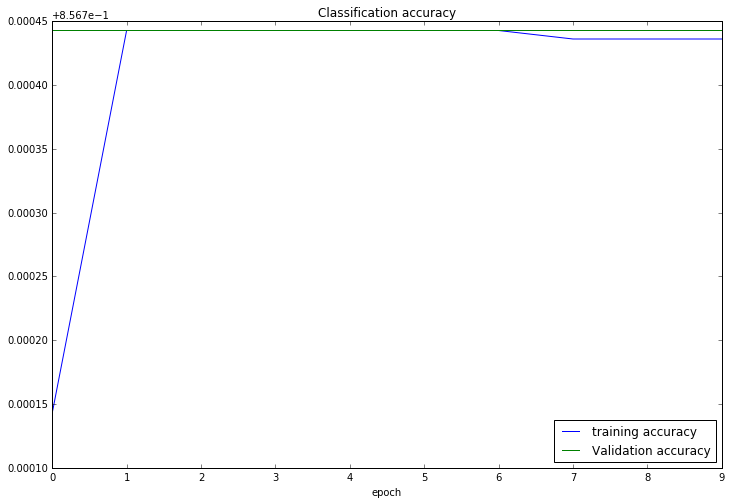

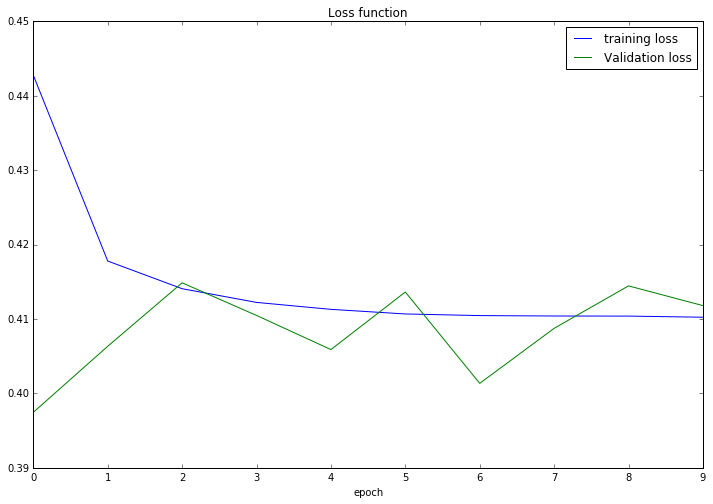

Classification accuracy = 0.857142865658
Epoch 1/5
21430/21430 [==============================] - 298s - loss: 0.2971 - acc: 0.8692 - val_loss: 0.2889 - val_acc: 0.8715
Epoch 2/5
21430/21430 [==============================] - 299s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2891 - val_acc: 0.8714
Epoch 3/5
21430/21430 [==============================] - 300s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2895 - val_acc: 0.8713
Epoch 4/5
21430/21430 [==============================] - 301s - loss: 0.2890 - acc: 0.8716 - val_loss: 0.2892 - val_acc: 0.8714
Epoch 5/5
21430/21430 [==============================] - 305s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2886 - val_acc: 0.8720
dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


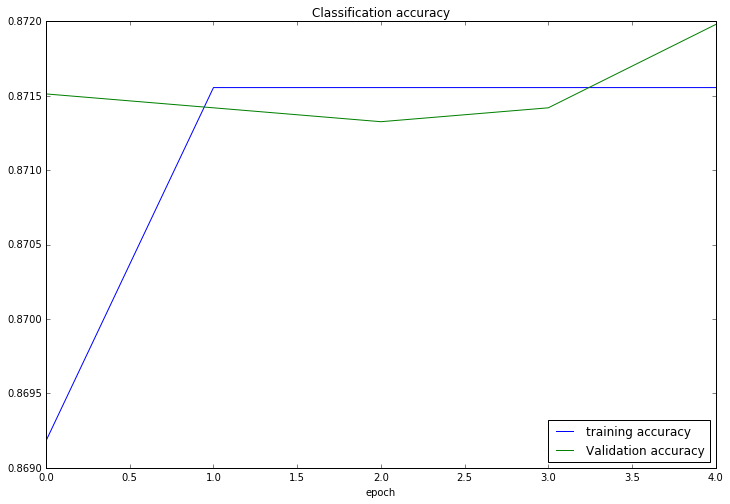

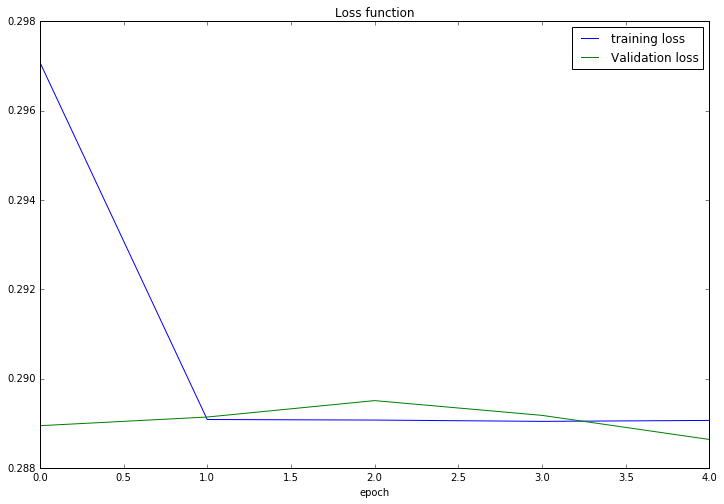

Classification accuracy = 0.871979106259
Test loss: 0.289967765855
Test accuracy: 0.870859389987


2018-03-01 12:53:35.069184: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [3]:
train_gen = generator("Run9goodDataQ_dualgate.root")
val_gen = gentrue(1)
test_gen = gentrue(2)

steps_t = 21430
steps_vt = 3062

from keras.models import load_model

mult = load_model("dummy.h5")

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=10, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

train_gen = gentrue(0)

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=10, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

mult.save("3network_random_label.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
21430/21430 [==============================] - 299s - loss: 0.2890 - acc: 0.8716 - val_loss: 0.2895 - val_acc: 0.8710
Epoch 2/5
21430/21430 [==============================] - 288s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2892 - val_acc: 0.8715
Epoch 3/5
21430/21430 [==============================] - 291s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2884 - val_acc: 0.8719
Epoch 4/5
21430/21430 [==============================] - 288s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2893 - val_acc: 0.8715
Epoch 5/5
21430/21430 [==============================] - 291s - loss: 0.2891 - acc: 0.8716 - val_loss: 0.2891 - val_acc: 0.8715
dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


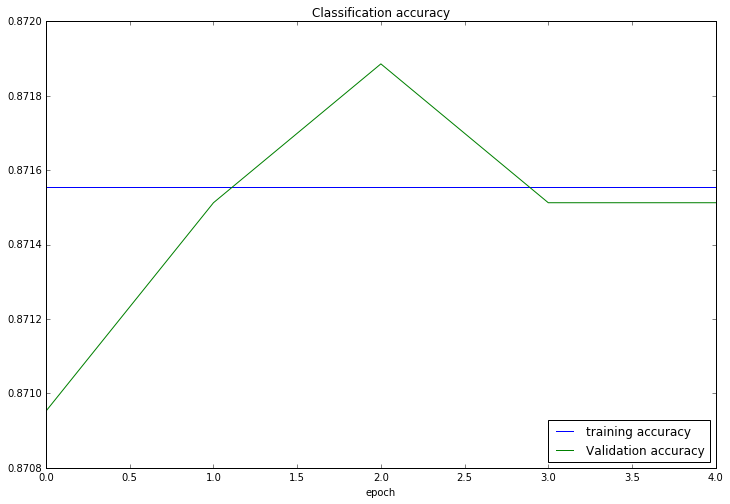

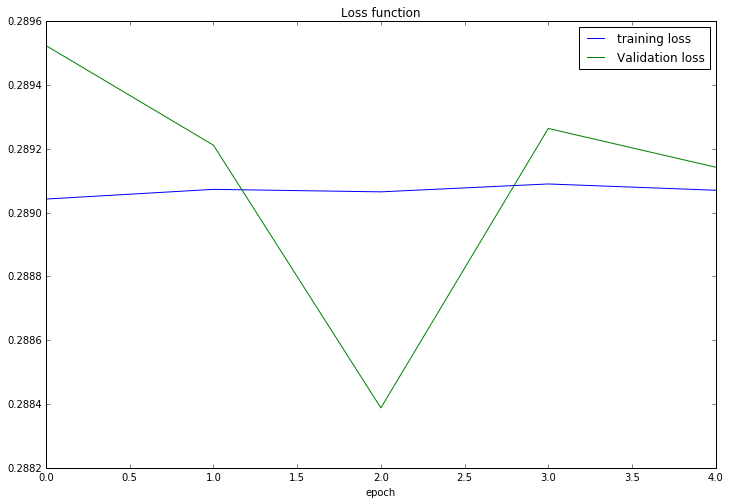

Classification accuracy = 0.871512557812
Test loss: 0.285916257457
Test accuracy: 0.872165725638


In [4]:
train_gen = gentrue(0)

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=5, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

mult.save("3network_random_label.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])